# Distinguish Your Own Digits (DYOD)

You are going to write a classifier that distinguishes between the number 3 and number 8.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

From the command line run `pip install mnist`. This is a library that will help you bring down the mnist dataset. If you run this from a notebook, you need to put  `!pip install mnist` in a cell by itself.

In [3]:
!pip install mnist

## Preparing the Data

In [4]:
import mnist

In [5]:
train_images = mnist.train_images()
train_labels = mnist.train_labels()

In [6]:
train_images.shape, train_labels.shape

((60000, 28, 28), (60000,))

In [7]:
test_images = mnist.test_images()
test_labels = mnist.test_labels()

In [8]:
test_images.shape, test_labels.shape

((10000, 28, 28), (10000,))

2


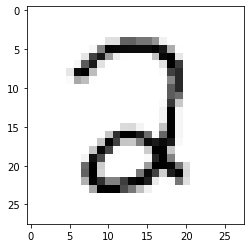

In [9]:
image_index = 7776 # You may select anything up to 60,000
print(train_labels[image_index]) 
plt.imshow(train_images[image_index], cmap='Greys')

## Filter data to get 3 and 8 out

In [10]:
train_filter = np.where((train_labels == 3 ) | (train_labels == 8))
test_filter = np.where((test_labels == 3) | (test_labels == 8))
X_train, y_train = train_images[train_filter], train_labels[train_filter]
X_test, y_test = test_images[test_filter], test_labels[test_filter]

We normalize the pizel values in the 0 to 1 range

In [11]:
X_train = X_train/255.
X_test = X_test/255.

And setup the labels as 1 (when the digit is 3) and 0 (when the digit is 8)

In [12]:
y_train = 1*(y_train==3)
y_test = 1*(y_test==3)

In [13]:
X_train.shape, X_test.shape

((11982, 28, 28), (1984, 28, 28))

We reshape the data to flatten the image pixels into a set of features or co-variates:

In [14]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_train.shape, X_test.shape

((11982, 784), (1984, 784))

In [15]:
#Impoting functions from 'Kudzu'
from kudzu.model import Model
from kudzu.train import Learner
from kudzu.optim import GD
from kudzu.data import Data, Sampler,Dataloader

from kudzu.callbacks import AccCallback
from kudzu.callbacks import ClfCallback

from kudzu.loss import MSE

from kudzu.layer import Sigmoid,Relu
from kudzu.layer import Affine

### Let us create a `Config` class, to store important parameters. 
This class essentially plays the role of a dictionary.

In [16]:
class Config:
    pass
config = Config()
config.lr = 0.001
config.num_epochs = 250
config.bs = 50

### Running Models with the Training data
Details about the network layers:
- A first affine layer has 784 inputs and does 100 affine transforms. These are followed by a Relu
- A second affine layer has 100 inputs from the 100 activations of the past layer, and does 100 affine transforms. These are followed by a Relu
- A third affine layer has 100 activations and does 2 affine transformations to create an embedding for visualization. There is no non-linearity here.
- A final "logistic regression" which has an affine transform from 2 inputs to 1 output, which is squeezed through a sigmoid.


In [17]:
data = Data(X_train, y_train.reshape(-1,1))
sampler = Sampler(data, config.bs, shuffle=True)

dl = Dataloader(data, sampler)

opt = GD(config.lr)
loss = MSE()

In [18]:
training_data_x = X_train
testing_data_x = X_test
training_data_y = y_train.reshape(-1,1)
testing_data_y = y_test.reshape(-1,1)

In [19]:
layers = [Affine("first", 784, 100), Relu("first"), Affine("second", 100, 100), Relu("second"), Affine("third", 100, 2), Affine("last", 2, 1), Sigmoid("last")]
model_nn = Model(layers)
model_lr = Model([Affine("logits", 784, 1), Sigmoid("sigmoid")])

xavier
xavier
xavier
xavier
xavier


In [20]:
nn_learner = Learner(loss, model_nn, opt, config.num_epochs)
acc_nn = ClfCallback(nn_learner, config.bs, training_data_x , testing_data_x, training_data_y, testing_data_y)
nn_learner.set_callbacks([acc_nn])

In [21]:
lr_learner = Learner(loss, model_lr, opt, config.num_epochs)
acc_lr = ClfCallback(lr_learner, config.bs, training_data_x , testing_data_x, training_data_y, testing_data_y)
lr_learner.set_callbacks([acc_lr])

In [22]:
nn_learner.train_loop(dl)

Epoch 0, Loss 0.2445
Training Accuracy: 0.5724, Testing Accuracy: 0.5882



Epoch 10, Loss 0.1502
Training Accuracy: 0.8908, Testing Accuracy: 0.8997



Epoch 20, Loss 0.076
Training Accuracy: 0.9251, Testing Accuracy: 0.9345



Epoch 30, Loss 0.0527
Training Accuracy: 0.9442, Testing Accuracy: 0.9551



Epoch 40, Loss 0.0427
Training Accuracy: 0.9535, Testing Accuracy: 0.9637



Epoch 50, Loss 0.0374
Training Accuracy: 0.9583, Testing Accuracy: 0.9667



Epoch 60, Loss 0.0341
Training Accuracy: 0.9601, Testing Accuracy: 0.9688



Epoch 70, Loss 0.0318
Training Accuracy: 0.9627, Testing Accuracy: 0.9693



Epoch 80, Loss 0.0301
Training Accuracy: 0.9644, Testing Accuracy: 0.9693



Epoch 90, Loss 0.0287
Training Accuracy: 0.9658, Testing Accuracy: 0.9693



Epoch 100, Loss 0.0275
Training Accuracy: 0.9675, Testing Accuracy: 0.9703



Epoch 110, Loss 0.0265
Training Accuracy: 0.9687, Testing Accuracy: 0.9703



Epoch 120, Loss 0.0256
Training Accuracy: 0.9701, Testing Accuracy: 0.9713



Epoch 130, Loss 0.0248
Training Accuracy: 0.9710, Testing Accuracy: 0.9718



Epoch 140, Loss 0.0241
Training Accuracy: 0.9713, Testing Accuracy: 0.9708



Epoch 150, Loss 0.0235
Training Accuracy: 0.9729, Testing Accuracy: 0.9703



Epoch 160, Loss 0.0228
Training Accuracy: 0.9738, Testing Accuracy: 0.9693



Epoch 170, Loss 0.0223
Training Accuracy: 0.9745, Testing Accuracy: 0.9703



Epoch 180, Loss 0.0217
Training Accuracy: 0.9751, Testing Accuracy: 0.9703



Epoch 190, Loss 0.0212
Training Accuracy: 0.9760, Testing Accuracy: 0.9703



Epoch 200, Loss 0.0207
Training Accuracy: 0.9766, Testing Accuracy: 0.9708



Epoch 210, Loss 0.0203
Training Accuracy: 0.9773, Testing Accuracy: 0.9708



Epoch 220, Loss 0.0199
Training Accuracy: 0.9772, Testing Accuracy: 0.9708



Epoch 230, Loss 0.0194
Training Accuracy: 0.9781, Testing Accuracy: 0.9713



Epoch 240, Loss 0.0191
Training Accuracy: 0.9785, Testing Accuracy: 0.9718



0.00788315581298527

In [23]:
lr_learner.train_loop(dl)

Epoch 0, Loss 0.2221
Training Accuracy: 0.7552, Testing Accuracy: 0.7878



Epoch 10, Loss 0.101
Training Accuracy: 0.9120, Testing Accuracy: 0.9224



Epoch 20, Loss 0.0782
Training Accuracy: 0.9291, Testing Accuracy: 0.9435



Epoch 30, Loss 0.0675
Training Accuracy: 0.9365, Testing Accuracy: 0.9496



Epoch 40, Loss 0.061
Training Accuracy: 0.9409, Testing Accuracy: 0.9531



Epoch 50, Loss 0.0565
Training Accuracy: 0.9448, Testing Accuracy: 0.9577



Epoch 60, Loss 0.0533
Training Accuracy: 0.9477, Testing Accuracy: 0.9582



Epoch 70, Loss 0.0508
Training Accuracy: 0.9493, Testing Accuracy: 0.9602



Epoch 80, Loss 0.0488
Training Accuracy: 0.9503, Testing Accuracy: 0.9602



Epoch 90, Loss 0.0471
Training Accuracy: 0.9520, Testing Accuracy: 0.9607



Epoch 100, Loss 0.0457
Training Accuracy: 0.9543, Testing Accuracy: 0.9607



Epoch 110, Loss 0.0445
Training Accuracy: 0.9550, Testing Accuracy: 0.9622



Epoch 120, Loss 0.0435
Training Accuracy: 0.9557, Testing Accuracy: 0.9627



Epoch 130, Loss 0.0426
Training Accuracy: 0.9560, Testing Accuracy: 0.9647



Epoch 140, Loss 0.0418
Training Accuracy: 0.9565, Testing Accuracy: 0.9642



Epoch 150, Loss 0.0411
Training Accuracy: 0.9566, Testing Accuracy: 0.9642



Epoch 160, Loss 0.0404
Training Accuracy: 0.9569, Testing Accuracy: 0.9647



Epoch 170, Loss 0.0398
Training Accuracy: 0.9576, Testing Accuracy: 0.9647



Epoch 180, Loss 0.0393
Training Accuracy: 0.9580, Testing Accuracy: 0.9652



Epoch 190, Loss 0.0387
Training Accuracy: 0.9586, Testing Accuracy: 0.9652



Epoch 200, Loss 0.0383
Training Accuracy: 0.9589, Testing Accuracy: 0.9662



Epoch 210, Loss 0.0378
Training Accuracy: 0.9594, Testing Accuracy: 0.9667



Epoch 220, Loss 0.0374
Training Accuracy: 0.9597, Testing Accuracy: 0.9667



Epoch 230, Loss 0.0371
Training Accuracy: 0.9599, Testing Accuracy: 0.9662



Epoch 240, Loss 0.0367
Training Accuracy: 0.9602, Testing Accuracy: 0.9662



0.05351355762299437

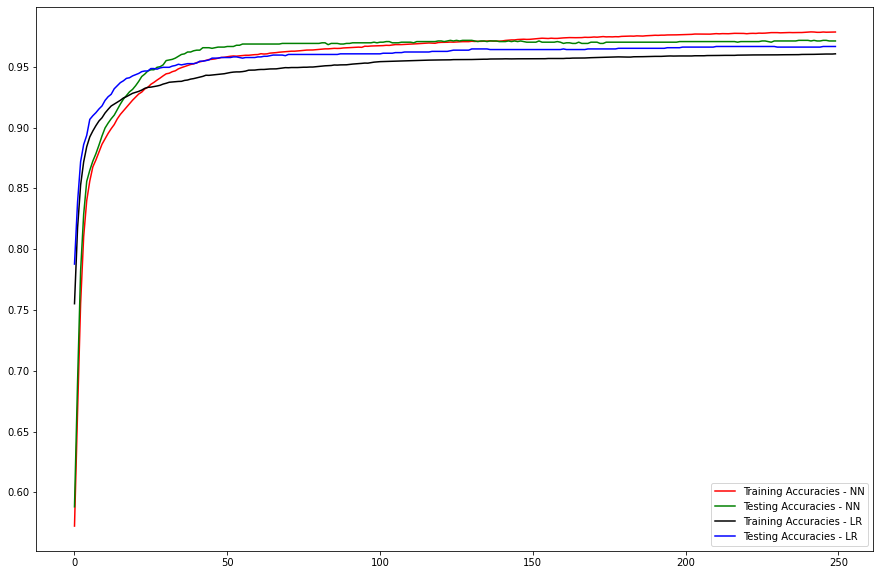

In [24]:
#comparing the results of NN and LR
plt.figure(figsize=(15,10))

# Neural Network plots
plt.plot(acc_nn.accuracies, 'r-', label = "Training Accuracies - NN")
plt.plot(acc_nn.test_accuracies, 'g-', label = "Testing Accuracies - NN")

# Logistic Regression plots
plt.plot(acc_lr.accuracies, 'k-', label = "Training Accuracies - LR")
plt.plot(acc_lr.test_accuracies, 'b-', label = "Testing Accuracies - LR")
plt.legend()

#### Plotting the outputs of this layer of the NN.


In [25]:
new_model = Model(layers[:-2])
testing_plot = new_model(testing_data_x)

Text(0.5, 1.0, 'Outputs')

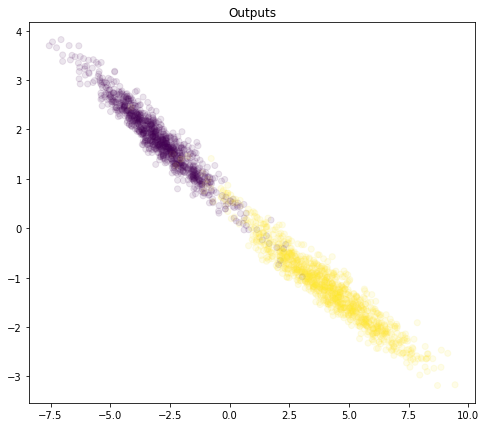

In [26]:
# Plotting the scatter plot of points and color coding by class
plt.figure(figsize=(8,7))
plt.scatter(testing_plot[:,0], testing_plot[:,1], alpha = 0.1, c = y_test.ravel());
plt.title('Outputs')

Probability contours

In [27]:
model_prob = Model(layers[-2:]) 

In [28]:
#creating the x and y ranges according to the above generated plot.
x_range = np.linspace(-4, 1, 100) 
y_range = np.linspace(-6, 6, 100) 
x_grid, y_grid = np.meshgrid(x_range, y_range) # x_grid and y_grig are of size 100 X 100

# converting x_grid and y_grid to continuous arrays
x_gridflat = np.ravel(x_grid)
y_gridflat = np.ravel(y_grid)

# The last layer of the current model takes two columns as input. Hence transpose of np.vstack() is required.
X = np.vstack((x_gridflat, y_gridflat)).T

prob_contour = model_prob(X).reshape(100,100) 

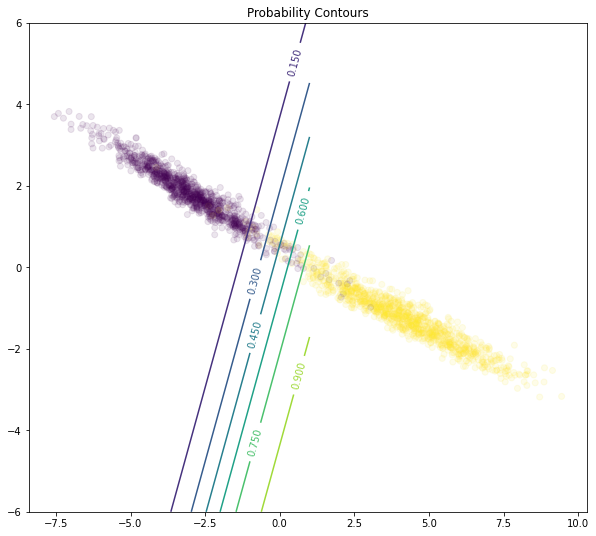

In [29]:
plt.figure(figsize=(10,9))
plt.scatter(testing_plot[:,0], testing_plot[:,1], alpha = 0.1, c = y_test.ravel())
contours = plt.contour(x_grid,y_grid,prob_contour)
plt.title('Probability Contours')
plt.clabel(contours, inline = True );